In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:



# Dataset pour le débruitage
class DenoisingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [
            os.path.join(root_dir, img) for img in os.listdir(root_dir)
            if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ]
        if not self.image_paths:
            raise ValueError(f"Aucune image valide trouvée dans le répertoire: {root_dir}")
        self.transform = transform

    def add_gaussian_noise(self, image, mean=0, std=0.3):
        noise = torch.randn_like(image) * std + mean
        return torch.clamp(image + noise, 0, 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        noisy_image = self.add_gaussian_noise(image)
        return noisy_image, image


# Transformations pour le dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Chargement du dataset BSD500
train_dataset = DenoisingDataset(root_dir='archive/images/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)




In [3]:
# Définition du générateur (CGNet)
class CGNet(nn.Module):
    def __init__(self):
        super(CGNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        return self.model(x)


# Définition du discriminateur
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = torch.mean(x, dim=(2, 3))  # Global average pooling
        return self.sigmoid(x)




In [4]:
# Initialisation des modèles
generator = CGNet().to(device)
discriminator = Discriminator().to(device)

# Critères et optimiseurs
pixelwise_loss = nn.MSELoss()
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Entraînement
num_epochs = 100
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    for noisy_imgs, clean_imgs in tqdm(train_loader):
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        # Labels pour le discriminateur
        batch_size = noisy_imgs.size(0)
        valid = torch.ones((batch_size, 1), device=device, requires_grad=False)
        fake = torch.zeros((batch_size, 1), device=device, requires_grad=False)

        # ----- Mise à jour du générateur -----
        optimizer_G.zero_grad()
        generated_imgs = generator(noisy_imgs)
        g_loss_pixelwise = pixelwise_loss(generated_imgs, clean_imgs)
        g_loss_adversarial = adversarial_loss(discriminator(generated_imgs), valid)
        g_loss = 0.001 * g_loss_adversarial + g_loss_pixelwise
        g_loss.backward()
        optimizer_G.step()

        # ----- Mise à jour du discriminateur -----
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(clean_imgs), valid)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Generator Loss: {g_loss.item():.4f} | Discriminator Loss: {d_loss.item():.4f}")

# Sauvegarde des modèles
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')




100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.94it/s]


Epoch [1/100] | Generator Loss: 0.0276 | Discriminator Loss: 0.3787


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


Epoch [2/100] | Generator Loss: 0.0272 | Discriminator Loss: 0.2097


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


Epoch [3/100] | Generator Loss: 0.0171 | Discriminator Loss: 0.1377


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


Epoch [4/100] | Generator Loss: 0.0166 | Discriminator Loss: 0.0932


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


Epoch [5/100] | Generator Loss: 0.0104 | Discriminator Loss: 0.2531


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [6/100] | Generator Loss: 0.0103 | Discriminator Loss: 0.1938


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


Epoch [7/100] | Generator Loss: 0.0090 | Discriminator Loss: 0.1463


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


Epoch [8/100] | Generator Loss: 0.0101 | Discriminator Loss: 0.0909


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


Epoch [9/100] | Generator Loss: 0.0103 | Discriminator Loss: 0.0706


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


Epoch [10/100] | Generator Loss: 0.0104 | Discriminator Loss: 0.0163


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


Epoch [11/100] | Generator Loss: 0.0112 | Discriminator Loss: 0.0245


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


Epoch [12/100] | Generator Loss: 0.0100 | Discriminator Loss: 0.0325


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


Epoch [13/100] | Generator Loss: 0.0094 | Discriminator Loss: 0.0350


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


Epoch [14/100] | Generator Loss: 0.0096 | Discriminator Loss: 0.1489


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


Epoch [15/100] | Generator Loss: 0.0096 | Discriminator Loss: 0.1112


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


Epoch [16/100] | Generator Loss: 0.0093 | Discriminator Loss: 0.0962


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


Epoch [17/100] | Generator Loss: 0.0083 | Discriminator Loss: 0.2014


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


Epoch [18/100] | Generator Loss: 0.0080 | Discriminator Loss: 0.3633


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


Epoch [19/100] | Generator Loss: 0.0088 | Discriminator Loss: 0.2918


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


Epoch [20/100] | Generator Loss: 0.0069 | Discriminator Loss: 0.5610


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


Epoch [21/100] | Generator Loss: 0.0082 | Discriminator Loss: 0.7229


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


Epoch [22/100] | Generator Loss: 0.0070 | Discriminator Loss: 0.7733


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


Epoch [23/100] | Generator Loss: 0.0074 | Discriminator Loss: 0.6462


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


Epoch [24/100] | Generator Loss: 0.0063 | Discriminator Loss: 0.4933


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


Epoch [25/100] | Generator Loss: 0.0074 | Discriminator Loss: 0.5233


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


Epoch [26/100] | Generator Loss: 0.0071 | Discriminator Loss: 0.4675


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


Epoch [27/100] | Generator Loss: 0.0069 | Discriminator Loss: 0.4356


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


Epoch [28/100] | Generator Loss: 0.0065 | Discriminator Loss: 0.4518


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


Epoch [29/100] | Generator Loss: 0.0068 | Discriminator Loss: 0.3526


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


Epoch [30/100] | Generator Loss: 0.0066 | Discriminator Loss: 0.3216


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


Epoch [31/100] | Generator Loss: 0.0073 | Discriminator Loss: 0.3426


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


Epoch [32/100] | Generator Loss: 0.0066 | Discriminator Loss: 0.3696


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


Epoch [33/100] | Generator Loss: 0.0078 | Discriminator Loss: 0.2234


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [34/100] | Generator Loss: 0.0074 | Discriminator Loss: 0.3461


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [35/100] | Generator Loss: 0.0072 | Discriminator Loss: 0.2070


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


Epoch [36/100] | Generator Loss: 0.0071 | Discriminator Loss: 0.1990


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


Epoch [37/100] | Generator Loss: 0.0077 | Discriminator Loss: 0.2580


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [38/100] | Generator Loss: 0.0079 | Discriminator Loss: 0.2913


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [39/100] | Generator Loss: 0.0077 | Discriminator Loss: 0.2441


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [40/100] | Generator Loss: 0.0075 | Discriminator Loss: 0.1923


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


Epoch [41/100] | Generator Loss: 0.0078 | Discriminator Loss: 0.2665


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


Epoch [42/100] | Generator Loss: 0.0070 | Discriminator Loss: 0.5449


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [43/100] | Generator Loss: 0.0084 | Discriminator Loss: 0.1513


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [44/100] | Generator Loss: 0.0085 | Discriminator Loss: 0.1307


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


Epoch [45/100] | Generator Loss: 0.0068 | Discriminator Loss: 0.3299


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


Epoch [46/100] | Generator Loss: 0.0074 | Discriminator Loss: 0.1784


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [47/100] | Generator Loss: 0.0077 | Discriminator Loss: 0.2662


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


Epoch [48/100] | Generator Loss: 0.0085 | Discriminator Loss: 0.1822


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


Epoch [49/100] | Generator Loss: 0.0081 | Discriminator Loss: 0.2599


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


Epoch [50/100] | Generator Loss: 0.0073 | Discriminator Loss: 0.2039


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


Epoch [51/100] | Generator Loss: 0.0078 | Discriminator Loss: 0.2292


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


Epoch [52/100] | Generator Loss: 0.0069 | Discriminator Loss: 0.2875


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


Epoch [53/100] | Generator Loss: 0.0068 | Discriminator Loss: 0.1400


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


Epoch [54/100] | Generator Loss: 0.0072 | Discriminator Loss: 0.3063


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


Epoch [55/100] | Generator Loss: 0.0086 | Discriminator Loss: 0.6067


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


Epoch [56/100] | Generator Loss: 0.0068 | Discriminator Loss: 0.1304


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [57/100] | Generator Loss: 0.0073 | Discriminator Loss: 0.2402


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


Epoch [58/100] | Generator Loss: 0.0079 | Discriminator Loss: 0.2602


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


Epoch [59/100] | Generator Loss: 0.0078 | Discriminator Loss: 0.2331


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


Epoch [60/100] | Generator Loss: 0.0084 | Discriminator Loss: 0.3270


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


Epoch [61/100] | Generator Loss: 0.0072 | Discriminator Loss: 0.3739


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


Epoch [62/100] | Generator Loss: 0.0076 | Discriminator Loss: 0.2096


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


Epoch [63/100] | Generator Loss: 0.0081 | Discriminator Loss: 0.3537


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


Epoch [64/100] | Generator Loss: 0.0079 | Discriminator Loss: 0.3022


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


Epoch [65/100] | Generator Loss: 0.0069 | Discriminator Loss: 0.2707


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


Epoch [66/100] | Generator Loss: 0.0069 | Discriminator Loss: 0.1658


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [67/100] | Generator Loss: 0.0071 | Discriminator Loss: 0.2680


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


Epoch [68/100] | Generator Loss: 0.0074 | Discriminator Loss: 0.2865


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [69/100] | Generator Loss: 0.0077 | Discriminator Loss: 0.1078


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [70/100] | Generator Loss: 0.0094 | Discriminator Loss: 0.5268


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [71/100] | Generator Loss: 0.0080 | Discriminator Loss: 0.2507


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


Epoch [72/100] | Generator Loss: 0.0084 | Discriminator Loss: 0.3159


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


Epoch [73/100] | Generator Loss: 0.0084 | Discriminator Loss: 0.4680


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


Epoch [74/100] | Generator Loss: 0.0081 | Discriminator Loss: 0.2280


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [75/100] | Generator Loss: 0.0071 | Discriminator Loss: 0.3620


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


Epoch [76/100] | Generator Loss: 0.0077 | Discriminator Loss: 0.1289


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [77/100] | Generator Loss: 0.0099 | Discriminator Loss: 0.6587


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


Epoch [78/100] | Generator Loss: 0.0092 | Discriminator Loss: 0.2486


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


Epoch [79/100] | Generator Loss: 0.0089 | Discriminator Loss: 0.2072


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [80/100] | Generator Loss: 0.0081 | Discriminator Loss: 0.1673


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


Epoch [81/100] | Generator Loss: 0.0076 | Discriminator Loss: 0.2082


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


Epoch [82/100] | Generator Loss: 0.0078 | Discriminator Loss: 0.1791


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


Epoch [83/100] | Generator Loss: 0.0082 | Discriminator Loss: 0.1451


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [84/100] | Generator Loss: 0.0086 | Discriminator Loss: 0.1767


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [85/100] | Generator Loss: 0.0073 | Discriminator Loss: 0.1115


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


Epoch [86/100] | Generator Loss: 0.0091 | Discriminator Loss: 0.0685


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


Epoch [87/100] | Generator Loss: 0.0066 | Discriminator Loss: 0.1195


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


Epoch [88/100] | Generator Loss: 0.0074 | Discriminator Loss: 0.2910


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


Epoch [89/100] | Generator Loss: 0.0077 | Discriminator Loss: 0.1077


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


Epoch [90/100] | Generator Loss: 0.0089 | Discriminator Loss: 0.1126


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


Epoch [91/100] | Generator Loss: 0.0094 | Discriminator Loss: 0.1749


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


Epoch [92/100] | Generator Loss: 0.0097 | Discriminator Loss: 0.1363


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


Epoch [93/100] | Generator Loss: 0.0091 | Discriminator Loss: 0.0813


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


Epoch [94/100] | Generator Loss: 0.0074 | Discriminator Loss: 0.0815


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


Epoch [95/100] | Generator Loss: 0.0096 | Discriminator Loss: 0.0592


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


Epoch [96/100] | Generator Loss: 0.0078 | Discriminator Loss: 0.0589


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


Epoch [97/100] | Generator Loss: 0.0093 | Discriminator Loss: 0.0296


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


Epoch [98/100] | Generator Loss: 0.0106 | Discriminator Loss: 0.0222


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


Epoch [99/100] | Generator Loss: 0.0094 | Discriminator Loss: 0.0861


100%|███████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]

Epoch [100/100] | Generator Loss: 0.0088 | Discriminator Loss: 0.0762


In [5]:
torch.save(generator, 'generator.pth')
torch.save(discriminator, 'discriminator.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20840529..1.3398693].


PSNR Noisy: 11.97, PSNR Generated: 23.66, PSNR Refined: 24.04, PSNR Fused: 23.08


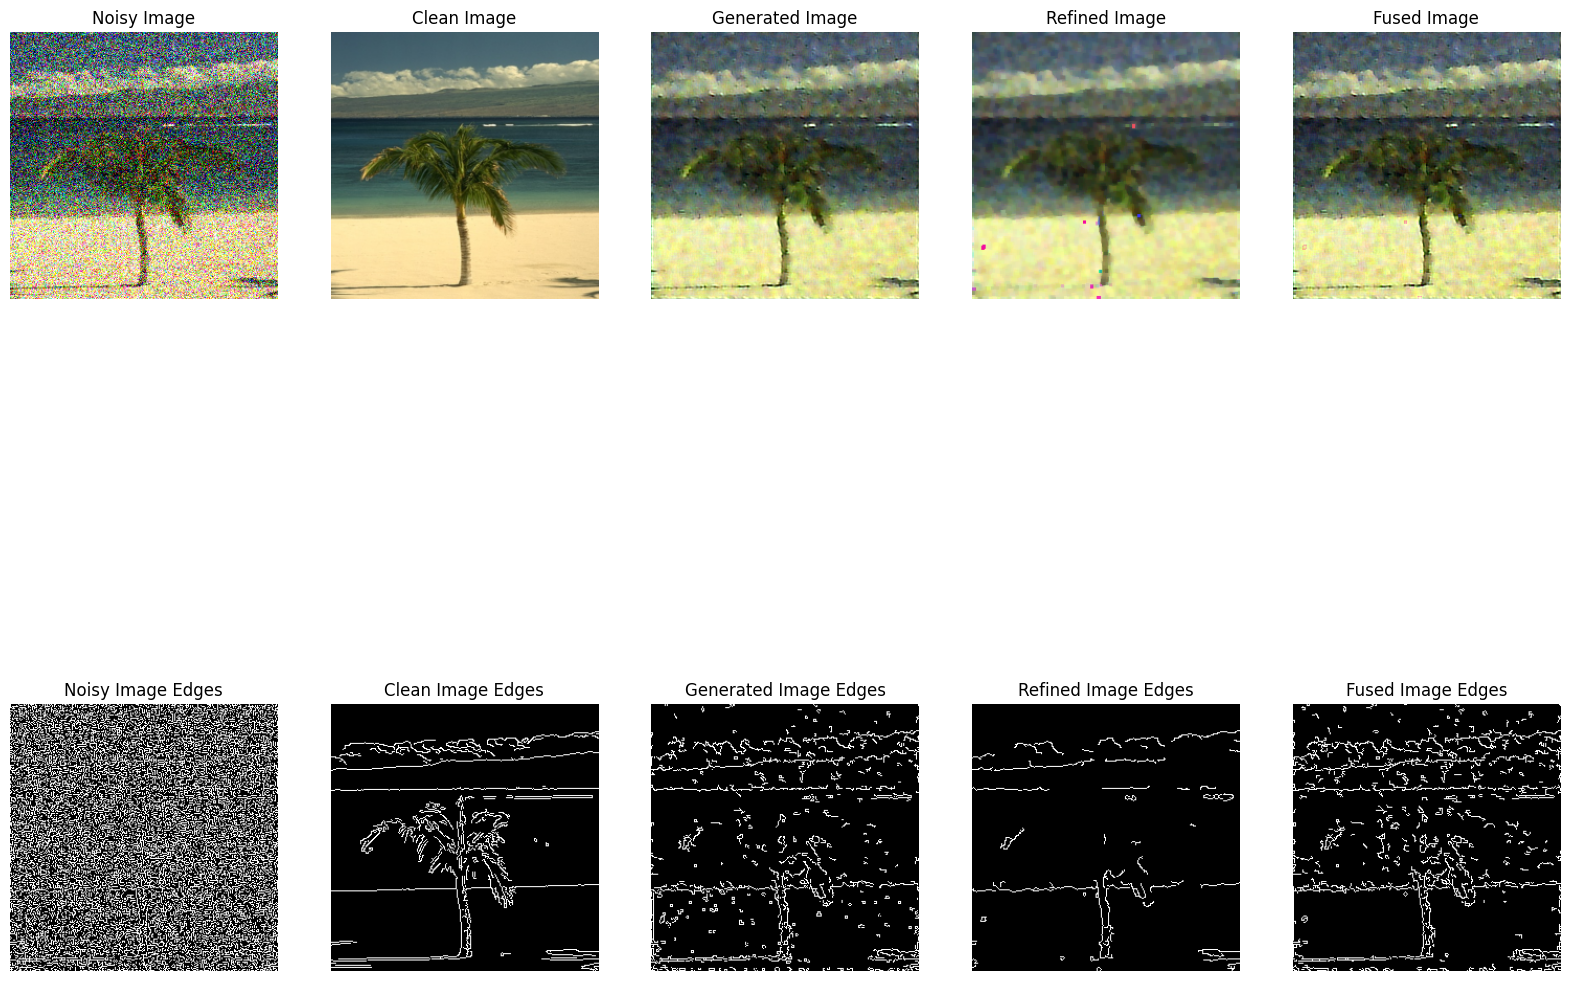

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5780514..1.4294773].


PSNR Noisy: 12.11, PSNR Generated: 23.02, PSNR Refined: 21.46, PSNR Fused: 22.54


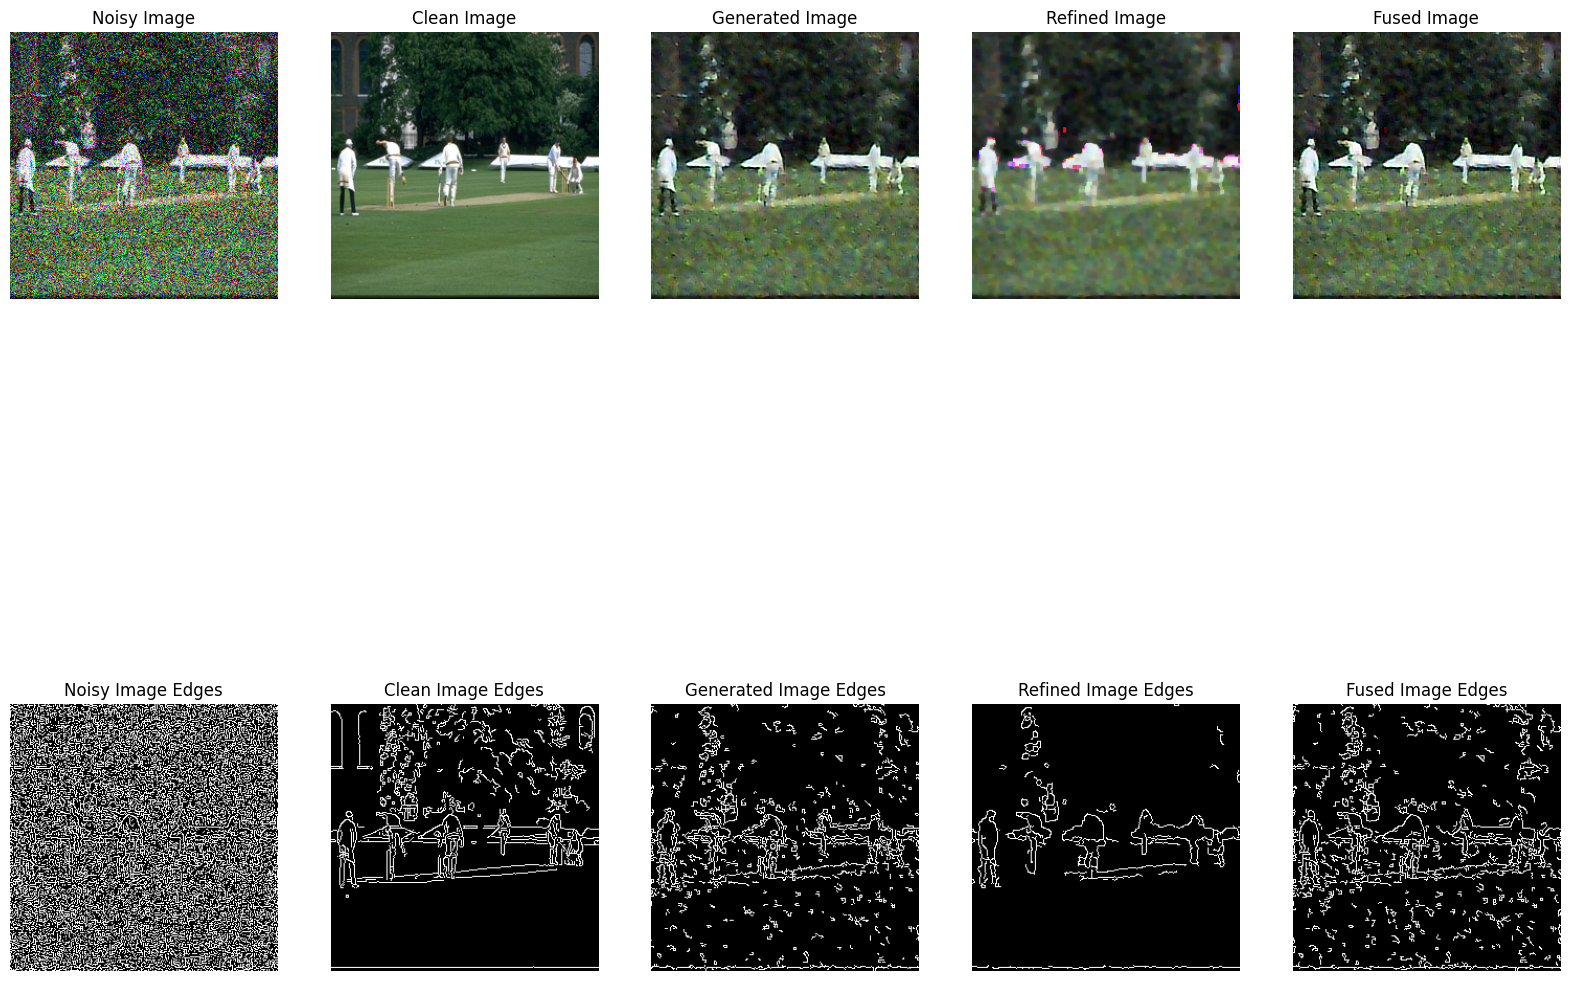

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3255444..1.2755402].


PSNR Noisy: 11.60, PSNR Generated: 22.44, PSNR Refined: 22.55, PSNR Fused: 21.77


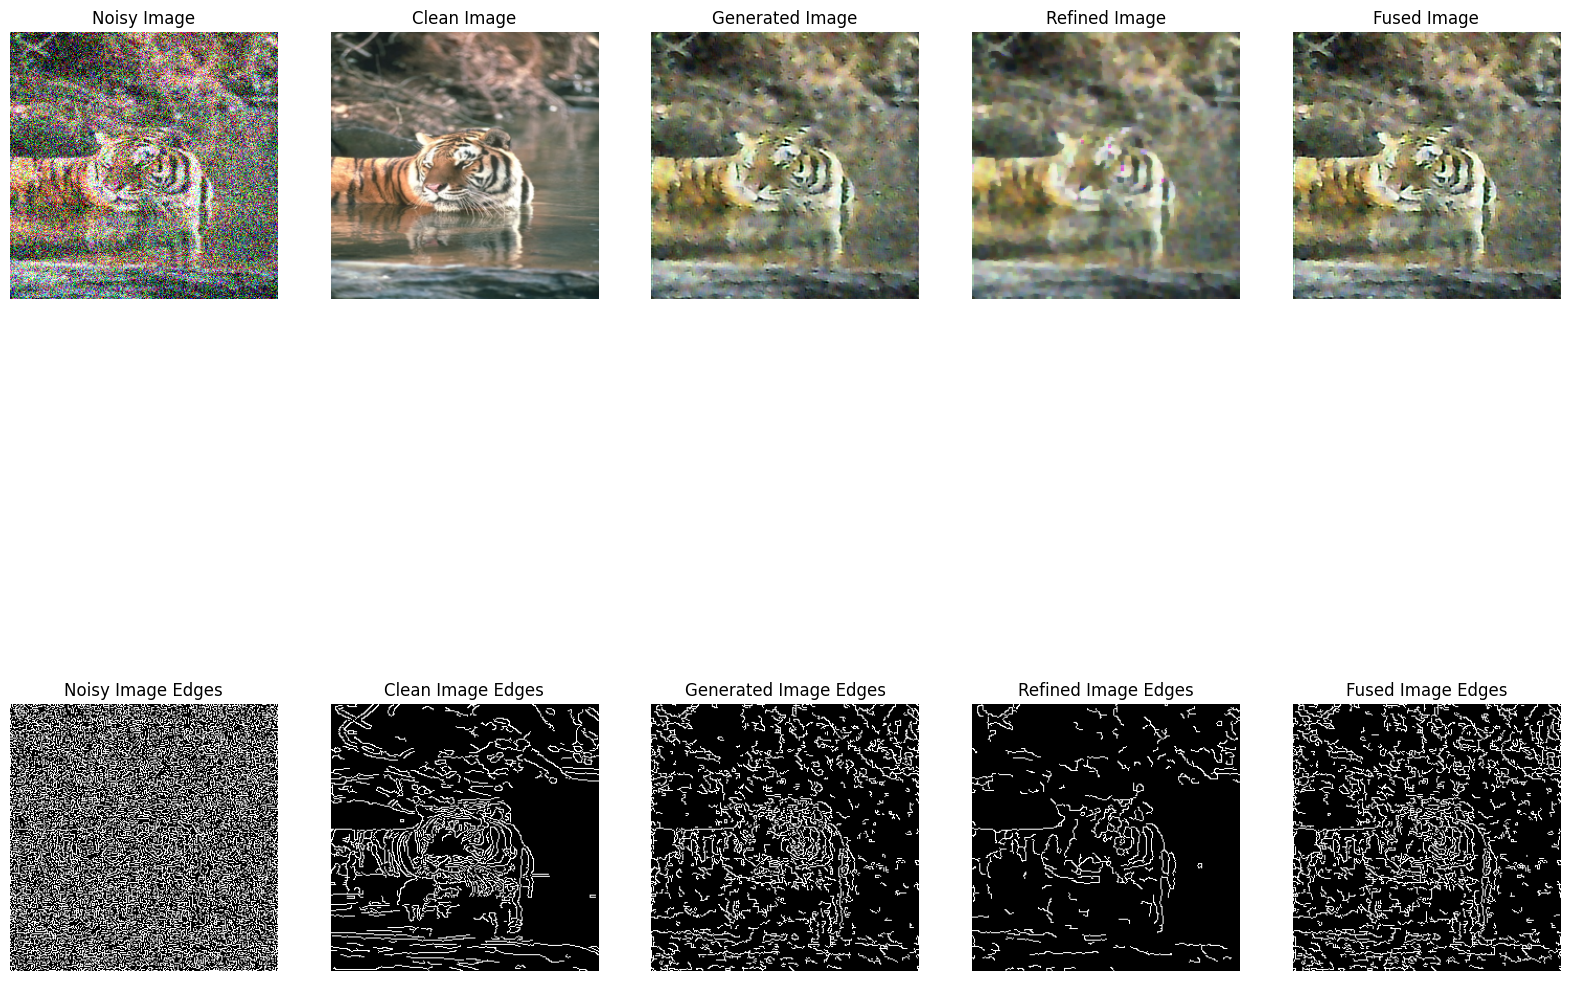

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28535992..1.2403815].


PSNR Noisy: 11.95, PSNR Generated: 23.64, PSNR Refined: 22.98, PSNR Fused: 22.99


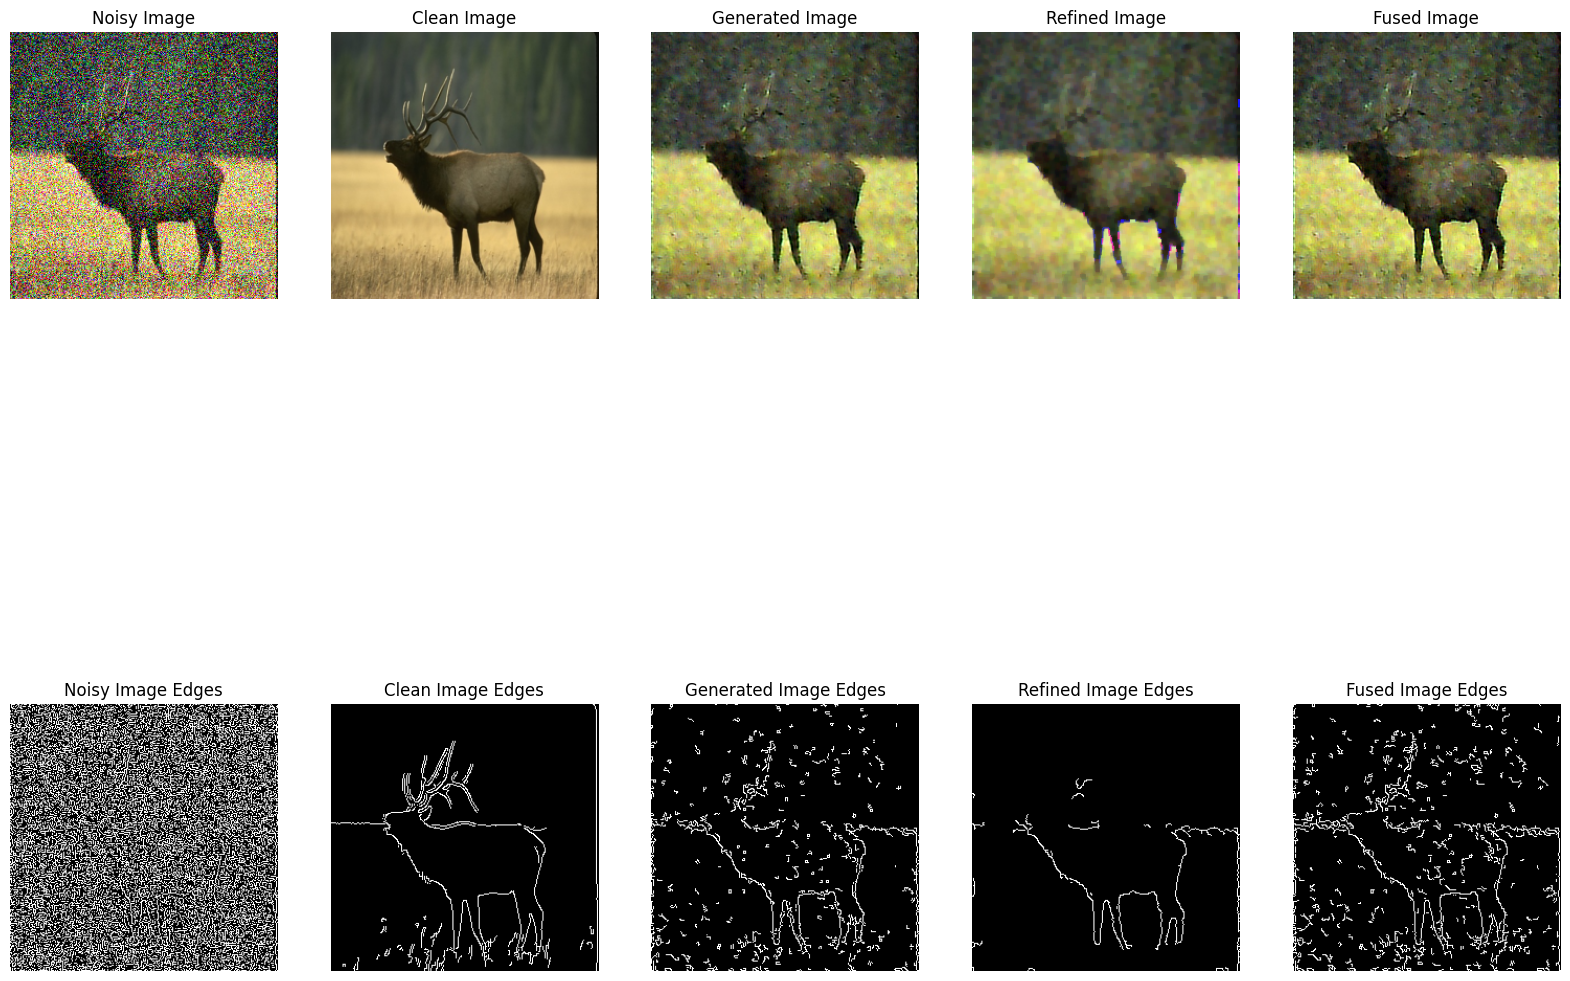

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11988965..1.1809002].


PSNR Noisy: 11.97, PSNR Generated: 24.42, PSNR Refined: 25.00, PSNR Fused: 23.95


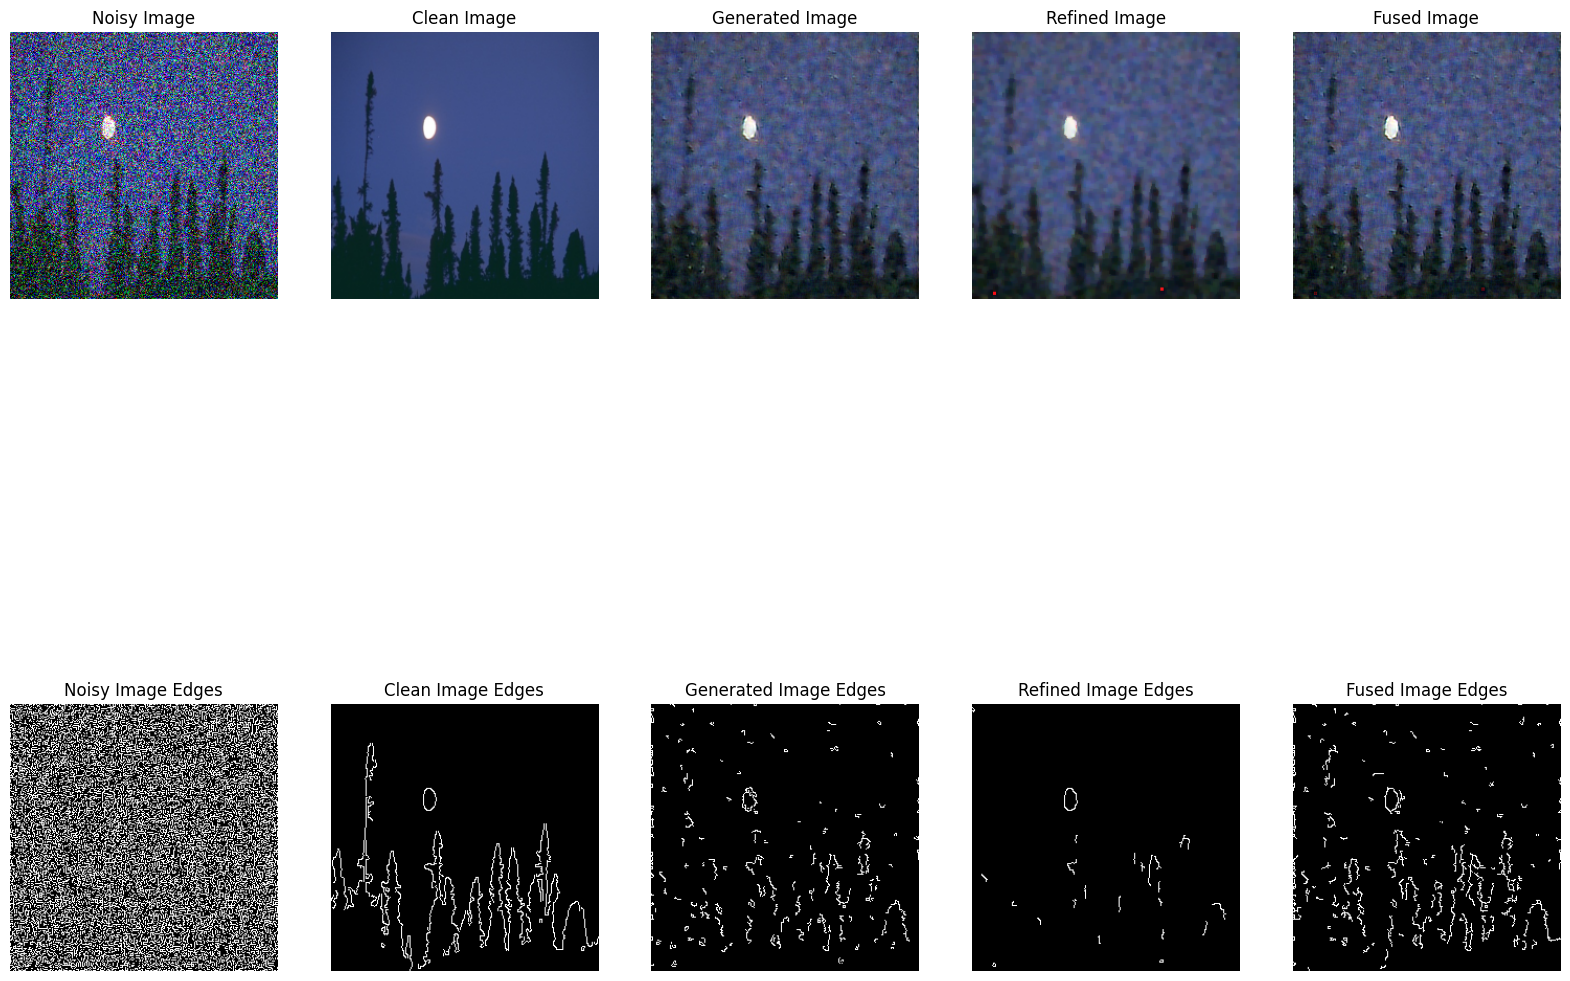

In [6]:
# Fonction pour appliquer plusieurs cycles de fermeture et ouverture sur chaque composante RGB
def apply_multiple_morphology_operations(generated_image, iterations=20):
    generated_np = generated_image.permute(1, 2, 0).cpu().numpy() * 255
    transformed_np = np.copy(generated_np)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    for _ in range(iterations):
        for i in range(3):
            channel = transformed_np[:, :, i].astype(np.uint8)
            channel_closed = cv2.morphologyEx(channel, cv2.MORPH_CLOSE, kernel)
            channel_opened = cv2.morphologyEx(channel_closed, cv2.MORPH_OPEN, kernel)
            transformed_np[:, :, i] = channel_opened

    return torch.tensor(transformed_np / 255.0).permute(2, 0, 1)


# Fonction pour fusionner avec les hautes fréquences
def fuse_with_high_frequencies(base_image, refined_image):
    base_np = base_image.permute(1, 2, 0).cpu().numpy() * 255
    refined_np = refined_image.permute(1, 2, 0).cpu().numpy() * 255

    refined_blur = cv2.GaussianBlur(refined_np, (5, 5), 0)
    high_freq = refined_np - refined_blur
    fused_np = np.clip(base_np + high_freq, 0, 255)

    return torch.tensor(fused_np / 255.0).permute(2, 0, 1)


# Fonction pour détecter les contours avec Canny
def detect_canny_edges(image):
    image_np = image.permute(1, 2, 0).cpu().numpy() * 255
    image_gray = cv2.cvtColor(image_np.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(image_gray, threshold1=100, threshold2=200)
    return torch.tensor(edges / 255.0).unsqueeze(0)


# Fonction d'affichage
def show_sample_with_metrics(generator, dataset, index, iterations=3):
    generator.eval()

    noisy_img, clean_img = dataset[index]
    noisy_img = noisy_img.unsqueeze(0).to(device)
    clean_img = clean_img.unsqueeze(0).to(device)

    with torch.no_grad():
        generated_img = generator(noisy_img)

    refined_img = apply_multiple_morphology_operations(generated_img.squeeze(), iterations=iterations)
    fused_img = fuse_with_high_frequencies(generated_img.squeeze(), refined_img)

    noisy_edges = detect_canny_edges(noisy_img.squeeze())
    clean_edges = detect_canny_edges(clean_img.squeeze())
    generated_edges = detect_canny_edges(generated_img.squeeze())
    refined_edges = detect_canny_edges(refined_img)
    fused_edges = detect_canny_edges(fused_img)

    # Calcul des PSNR
    psnr_noisy = psnr(clean_img.squeeze().permute(1, 2, 0).cpu().numpy(), noisy_img.squeeze().permute(1, 2, 0).cpu().numpy())
    psnr_generated = psnr(clean_img.squeeze().permute(1, 2, 0).cpu().numpy(), generated_img.squeeze().permute(1, 2, 0).cpu().numpy())
    psnr_refined = psnr(clean_img.squeeze().permute(1, 2, 0).cpu().numpy(), refined_img.permute(1, 2, 0).cpu().numpy())
    psnr_fused = psnr(clean_img.squeeze().permute(1, 2, 0).cpu().numpy(), fused_img.permute(1, 2, 0).cpu().numpy())

    print(f"PSNR Noisy: {psnr_noisy:.2f}, PSNR Generated: {psnr_generated:.2f}, PSNR Refined: {psnr_refined:.2f}, PSNR Fused: {psnr_fused:.2f}")

    plt.figure(figsize=(20, 16))

    images = [
        (noisy_img, noisy_edges, "Noisy Image"),
        (clean_img, clean_edges, "Clean Image"),
        (generated_img, generated_edges, "Generated Image"),
        (refined_img, refined_edges, "Refined Image"),
        (fused_img, fused_edges, "Fused Image"),
    ]

    for i, (image, edge, title) in enumerate(images):
        plt.subplot(2, 5, i + 1)
        plt.title(title)
        plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.subplot(2, 5, i + 6)
        plt.title(f"{title} Edges")
        plt.imshow(edge.squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')

    plt.show()


# Exemple d'affichage
for idx in range(5):  # Affiche les 5 premiers échantillons
    show_sample_with_metrics(generator, train_dataset, idx, iterations=3)
